# Installs & Imports

In [1]:
!pip install -q pygam numpy==2.0.0 scipy==1.13.0 scikit-learn rolch

In [2]:
import numpy, scipy, sklearn, pygam, rolch
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)
print("Scikit-learn:", sklearn.__version__)
print("PyGAM:", pygam.__version__)
print("rolch:", rolch.__version__)

NumPy: 2.0.0
SciPy: 1.13.0
Scikit-learn: 1.6.1
PyGAM: 0.8.0
rolch: 0.2.2


In [3]:
# Quick alias patch
import numpy as np
np.int = int
np.float = float
np.bool = bool

In [4]:
import logging
import re
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from patsy import dmatrix
from scipy.optimize import minimize_scalar
from scipy.stats import t as student_t
from tqdm.auto import tqdm

from rolch import DistributionT, OnlineGamlss
from pygam import LinearGAM, GammaGAM, s
from pygam.terms import TermList

# Enable DEBUG logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Utilities

In [5]:
DMATRIX_KEY = Tuple[Tuple[str, ...], int, int, str]

def prepare_X(X: Any, *, logger: Optional[logging.Logger] = None) -> pd.DataFrame:
    log = logger or logging.getLogger(__name__)
    if isinstance(X, pd.DataFrame):
        X_df = X.copy()
    else:
        arr = np.array(X, dtype=float)
        if arr.ndim != 2:
            raise ValueError(f"Expected 2-D array, got ndim={arr.ndim}")
        X_df = pd.DataFrame(arr, columns=[f"x{i}" for i in range(arr.shape[1])])
    if not np.isfinite(X_df.values).all():
        raise ValueError("X contains NaN or infinite values")
    log.debug(f"prepare_X → shape={X_df.shape}, columns={X_df.columns.tolist()}")
    return X_df

def validate_y(y: Any, n: int, *, logger: Optional[logging.Logger] = None) -> np.ndarray:
    log = logger or logging.getLogger(__name__)
    arr = np.array(y, dtype=float)
    if arr.ndim != 1:
        raise ValueError(f"y must be 1-D, got ndim={arr.ndim}")
    if arr.shape[0] != n:
        raise ValueError(f"y length {arr.shape[0]} ≠ expected {n}")
    if not np.isfinite(arr).all():
        raise ValueError("y contains NaN or infinite values")
    log.debug(f"validate_y → length={n}")
    return arr

In [6]:
def get_combos(
    df_cand: List[int],
    deg_cand: List[int],
    random_search: bool,
    max_evals: Optional[int],
    random_state: Optional[int],
    *, logger: Optional[logging.Logger]
) -> List[Tuple[int,int]]:
    log = logger or logging.getLogger(__name__)
    if not df_cand or not deg_cand:
        raise ValueError("df and degree candidates must be non-empty")
    combos = [
        (d, k)
        for d in df_cand
        for k in deg_cand
        if d > k
    ]
    if not random_search:
        if max_evals is not None:
            log.warning("max_evals ignored when random_search=False")
        return combos
    if not max_evals or max_evals < 1:
        raise ValueError("random_search=True requires positive max_evals")
    rng = np.random.default_rng(random_state)
    idx = rng.choice(len(combos), size=min(len(combos), max_evals), replace=False)
    return [combos[i] for i in idx]

In [7]:
def make_pygam_terms(n_features: int, n_splines: int, spline_order: int) -> TermList:
    """
    Build a pygam.TermList of s(i) terms for features 0..n_features-1.
    """
    if n_features < 1:
        raise ValueError("n_features must be >= 1")
    # Start with the first term
    term = s(0, n_splines=n_splines, spline_order=spline_order)
    # Add the rest
    for i in range(1, n_features):
        term += s(i, n_splines=n_splines, spline_order=spline_order)
    return term

def make_rolch_formula(cols: List[str], n_splines: int, spline_order: int) -> str:
    safe = re.compile(r"^[A-Za-z_]\w*$").fullmatch
    terms = []
    for c in cols:
        if not safe(c):
            raise ValueError(f"Invalid column name: {c!r}")
        terms.append(f"bs({c}, df={n_splines}, degree={spline_order}, include_intercept=False)")
    return "1 + " + " + ".join(terms)

In [8]:
def build_dmatrix(
    key: DMATRIX_KEY,
    formula: str,
    X_df: pd.DataFrame,
    cache: Dict[DMATRIX_KEY,pd.DataFrame],
    *, logger: Optional[logging.Logger]
) -> np.ndarray:
    log = logger or logging.getLogger(__name__)
    if key in cache:
        log.debug(f"build_dmatrix: cache hit {key}")
    else:
        log.debug(f"build_dmatrix: building design matrix for {key}")
        cache[key] = dmatrix(formula, X_df, return_type="dataframe")
    return cache[key].values

# GAMLSS Class

In [9]:
class GAMLSSFitError(Exception):
    pass

In [10]:
class CustomGAMLSS:
    def __init__(
        self,
        engine: str = "pygam",
        df_candidates: Optional[List[int]] = None,
        degree_candidates: Optional[List[int]] = None,
        lam_candidates: Optional[List[float]] = None,
        fit_shape: bool = True,
        shape_bounds: Tuple[float,float] = (2.01,100),
        distribution: Any = None,
        verbose: bool = False,
        random_search: bool = False,
        max_evals: Optional[int] = None,
        random_state: Optional[int] = None,
        equation: Optional[Dict[int,str]] = None
    ) -> None:
        # Logger
        self.logger = logger
        self.logger.setLevel(logging.DEBUG if verbose else logging.INFO)

        # Engine
        e = engine.lower().strip()
        if e not in ("pygam","rolch"):
            raise ValueError("engine must be 'pygam' or 'rolch'")
        self.engine = e

        # Grids
        self.df_candidates = df_candidates or [5, 8, 12]
        self.degree_candidates = degree_candidates or [3, 4]
        self.lam_candidates = lam_candidates or np.logspace(-3, 3, 7).tolist()
        self.random_search = random_search
        self.max_evals = max_evals
        self.random_state = random_state

        # Shape
        low, high = shape_bounds
        if low <= 0 or high <= low:
            raise ValueError("invalid shape_bounds")
        self.fit_shape, self.shape_bounds = fit_shape, shape_bounds

        # Rolch
        self.distribution = distribution or DistributionT()
        self.equation = equation

        # Placeholders
        self.mu_model = None
        self.var_model = None
        self.model = None
        self.nu_ = None
        self.shape_fit_result_ = None

        # Caches and tracking
        self._dmatrix_cache: Dict[DMATRIX_KEY,pd.DataFrame] = {}
        self._predict_dmatrix_cache: Dict[DMATRIX_KEY,pd.DataFrame] = {}
        self._rolch_basis_cols: Dict[DMATRIX_KEY,List[str]] = {}
        self.tuning_history_: Dict[str,pd.DataFrame] = {}

    def clear_cache(self) -> None:
        self._dmatrix_cache.clear()
        self._predict_dmatrix_cache.clear()
        self.logger.debug("Caches cleared")

    def _fit_shape_mle(self, y, mu, sigma) -> float:
        def nll(log_nu):
            nu = np.exp(log_nu)
            return -np.sum(student_t.logpdf(y, df=nu, loc=mu, scale=sigma))
        lb,ub = np.log(self.shape_bounds[0]), np.log(self.shape_bounds[1])
        res = minimize_scalar(nll, bounds=(lb, ub), method="bounded")
        self.shape_fit_result_ = res
        if not res.success:
            raise GAMLSSFitError(f"Shape MLE failed: {res.message}")
        nu_hat = float(np.exp(res.x))
        self.logger.debug(f"Shape MLE → ν={nu_hat:.4f}")
        return nu_hat

    def _grid_search_gam(self, X, y, GamClass, label):
        history, best_aic = [], np.inf
        best_model, best_params = None, None
        n,p = X.shape
        combos = get_combos(
            self.df_candidates,
            self.degree_candidates,
            self.random_search,
            self.max_evals,
            self.random_state,
            logger=self.logger
        )
        for df_, ord_ in tqdm(combos, desc=f"pyGAM {label}", leave=False):
            terms = make_pygam_terms(p, df_, ord_)
            gam = GamClass(terms)
            try:
                gam.gridsearch(X, y, lam=self.lam_candidates, progress=False)
            except Exception as e:
                self.logger.error(f"pyGAM skip {label} (df={df_}, ord={ord_}): {e}")
                continue
            aic = gam.statistics_["AIC"]
            lam = float(np.mean(gam.lam))
            history.append({"n_splines": df_, "order": ord_, "lam": lam, "AIC": aic})
            if aic < best_aic:
                best_aic, best_model, best_params = aic, gam, (df_, ord_, lam)
        if best_model is None:
            raise GAMLSSFitError(f"No successful {label}-GAM fits.")
        self.tuning_history_[label] = pd.DataFrame(history)
        df_, ord_, lam = best_params
        self.logger.info(f"Best {label}: df={df_}, order={ord_}, lam={lam:.3g}, AIC={best_aic:.2f}")
        return best_model

    def _fit_pygam(self, X, y):
        # μ-model
        self.mu_model = self._grid_search_gam(X, y, LinearGAM, "mu")
        mu = self.mu_model.predict(X)
        # σ²-model
        res2 = np.maximum((y-mu)**2, np.finfo(float).eps)
        self.var_model = self._grid_search_gam(X, res2, GammaGAM, "sigma2")
        sigma = np.sqrt(self.var_model.predict(X))
        # ν-model
        self.nu_ = self._fit_shape_mle(y, mu, sigma) if self.fit_shape else None
        return self

    def _fit_rolch(self, X_df: pd.DataFrame, y: np.ndarray):
        cols = X_df.columns.tolist()
        best_bic = np.inf
        history = []
        combos = get_combos(
            self.df_candidates,
            self.degree_candidates,
            self.random_search,
            self.max_evals,
            self.random_state,
            logger=self.logger
        )
        for df_, ord_ in tqdm(combos, desc="rolch tuning", leave=False):
            formula = make_rolch_formula(cols, df_, ord_)
            key = (tuple(cols), df_, ord_, formula)
            # Full basis
            Xb_full = build_dmatrix(key, formula, X_df, self._dmatrix_cache, logger=self.logger)
            dfm = self._dmatrix_cache[key]
            # Drop zero-variance cols
            variances = dfm.var(axis=0)
            kept = variances[variances > 0].index.tolist()
            if len(kept) < dfm.shape[1]:
                self.logger.info(f"Dropped {dfm.shape[1] - len(kept)} constant cols for df={df_}, ord={ord_}")
            Xb = dfm[kept].values
            self._rolch_basis_cols[key] = kept

            mdl = OnlineGamlss(
                distribution=self.distribution,
                method="lasso",
                equation=self.equation or {i:"all" for i in range(3 if self.fit_shape else 2)},
                fit_intercept=True,
                ic="bic",
                scale_inputs=True
            )
            try:
                mdl.fit(Xb, y)
            except Exception as e:
                self.logger.error(f"rolch skip df={df_}, ord={ord_}: {e}")
                continue

            dev = mdl.global_dev
            p_nz = sum(np.count_nonzero(coefs) for coefs in mdl.beta.values())
            bic = dev + np.log(len(y)) * p_nz
            history.append({"n_splines": df_, "order": ord_, "BIC": bic})
            if bic < best_bic:
                best_bic, self.model, self._rolch_formula, self.df_rolch, self.degree_rolch = bic, mdl, formula, df_, ord_

        if self.model is None:
            raise GAMLSSFitError("All rolch fits failed.")
        self.tuning_history_["rolch"] = pd.DataFrame(history)

        # Global ν
        if self.fit_shape:
            key = (tuple(cols), self.df_rolch, self.degree_rolch, self._rolch_formula)
            # Rebuild and drop same columns
            Xb_full = build_dmatrix(key, self._rolch_formula, X_df, self._predict_dmatrix_cache, logger=self.logger)
            dfm = self._predict_dmatrix_cache[key]
            Xb_train = dfm[self._rolch_basis_cols[key]].values
            theta = self.model.predict(Xb_train)
            self.nu_ = float(np.mean(theta[:,2]))
        return self

    def fit(self, X: Any, y: Any) -> "CustomGAMLSS":
        self.clear_cache()
        X_df = prepare_X(X, logger=self.logger)
        y_arr = validate_y(y, X_df.shape[0], logger=self.logger)
        if self.engine == "pygam":
            return self._fit_pygam(X_df.values, y_arr)
        else:
            return self._fit_rolch(X_df, y_arr)

    def predict(self, X: Any) -> Tuple[np.ndarray,np.ndarray,Optional[float]]:
        X_df = prepare_X(X, logger=self.logger)
        self._predict_dmatrix_cache.clear()
        if self.engine == "pygam":
            mu = self.mu_model.predict(X_df.values)
            sigma = np.sqrt(self.var_model.predict(X_df.values))
            return mu, sigma, self.nu_

        cols = X_df.columns.tolist()
        key = (tuple(cols), self.df_rolch, self.degree_rolch, self._rolch_formula)
        Xb_full = build_dmatrix(key, self._rolch_formula, X_df, self._predict_dmatrix_cache, logger=self.logger)
        dfm = self._predict_dmatrix_cache[key]
        Xb_new = dfm[self._rolch_basis_cols[key]].values
        theta = self.model.predict(Xb_new)
        mu, sigma = theta[:,0], theta[:,1]
        return mu, sigma, self.nu_

# Demo Workflow

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Load the data
data = load_diabetes(as_frame=True)
X = data.data
y = data.target.values

In [12]:
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Sort test set by true y for plotting
order_test = np.argsort(y_test)
X_test_s = X_test.iloc[order_test].reset_index(drop=True)
y_test_s = y_test[order_test]

In [13]:
# Fit CustomGAMLSS with pyGAM
gamlss_pygam = CustomGAMLSS(
    engine="pygam",
    df_candidates=[3, 5, 8, 12],
    degree_candidates=[2, 3, 4],
    lam_candidates=[0.1, 1],
    fit_shape=True,
    verbose=False
)
gamlss_pygam.fit(X_train, y_train)

pyGAM mu:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:Best mu: df=5, order=4, lam=0.1, AIC=6307.77


pyGAM sigma2:   0%|          | 0/10 [00:00<?, ?it/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


INFO:__main__:Best sigma2: df=3, order=2, lam=0.1, AIC=6152.61


did not converge


In [14]:
# Fit CustomGAMLSS with rolch
gamlss_rolch = CustomGAMLSS(
    engine="rolch",
    df_candidates=[3, 5, 8, 12],
    degree_candidates=[2, 3, 4],
    fit_shape=True,
    verbose=False
)
gamlss_rolch.fit(X_train, y_train)

rolch tuning:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:Dropped 2 constant cols for df=3, ord=2
INFO:__main__:Dropped 5 constant cols for df=5, ord=2
INFO:__main__:Dropped 5 constant cols for df=5, ord=3
INFO:__main__:Dropped 4 constant cols for df=5, ord=4
INFO:__main__:Dropped 8 constant cols for df=8, ord=2
INFO:__main__:Dropped 8 constant cols for df=8, ord=3
INFO:__main__:Dropped 8 constant cols for df=8, ord=4
INFO:__main__:Dropped 13 constant cols for df=12, ord=2
INFO:__main__:Dropped 12 constant cols for df=12, ord=3
INFO:__main__:Dropped 12 constant cols for df=12, ord=4


In [15]:
# Fit Linear Regression + CI via statsmodels
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test_s)

ols = sm.OLS(y_train, X_train_const).fit()

In [16]:
# Predictions and 95% Student-t (for GAMLSS models) intervals

# Model via pyGAM
mu_pg, sigma_pg, nu_pg = gamlss_pygam.predict(X_test_s)
tcrit_pg = t.ppf(0.975, df=nu_pg)
lower_pg = mu_pg - tcrit_pg * sigma_pg
upper_pg = mu_pg + tcrit_pg * sigma_pg

# Model via rolch
mu_rl, sigma_rl, nu_rl = gamlss_rolch.predict(X_test_s)
tcrit_rl = t.ppf(0.975, df=nu_rl)
lower_rl = mu_rl - tcrit_rl * sigma_rl
upper_rl = mu_rl + tcrit_rl * sigma_rl

# Linear Regression
pred = ols.get_prediction(X_test_const)
pred_summary = pred.summary_frame(alpha=0.05)

mu_lr = pred_summary["mean"].values
lower_obs = pred_summary["obs_ci_lower"]
upper_obs = pred_summary["obs_ci_upper"]

In [17]:
# Test RMSE
def rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

print("Test RMSE:")
print(f"  pyGAM: {rmse(y_test_s, mu_pg):.3f}")
print(f"  rolch: {rmse(y_test_s, mu_rl):.3f}")
print(f"  Linear: {rmse(y_test_s, mu_lr):.3f}")

Test RMSE:
  pyGAM: 52.843
  rolch: 52.224
  Linear: 53.853


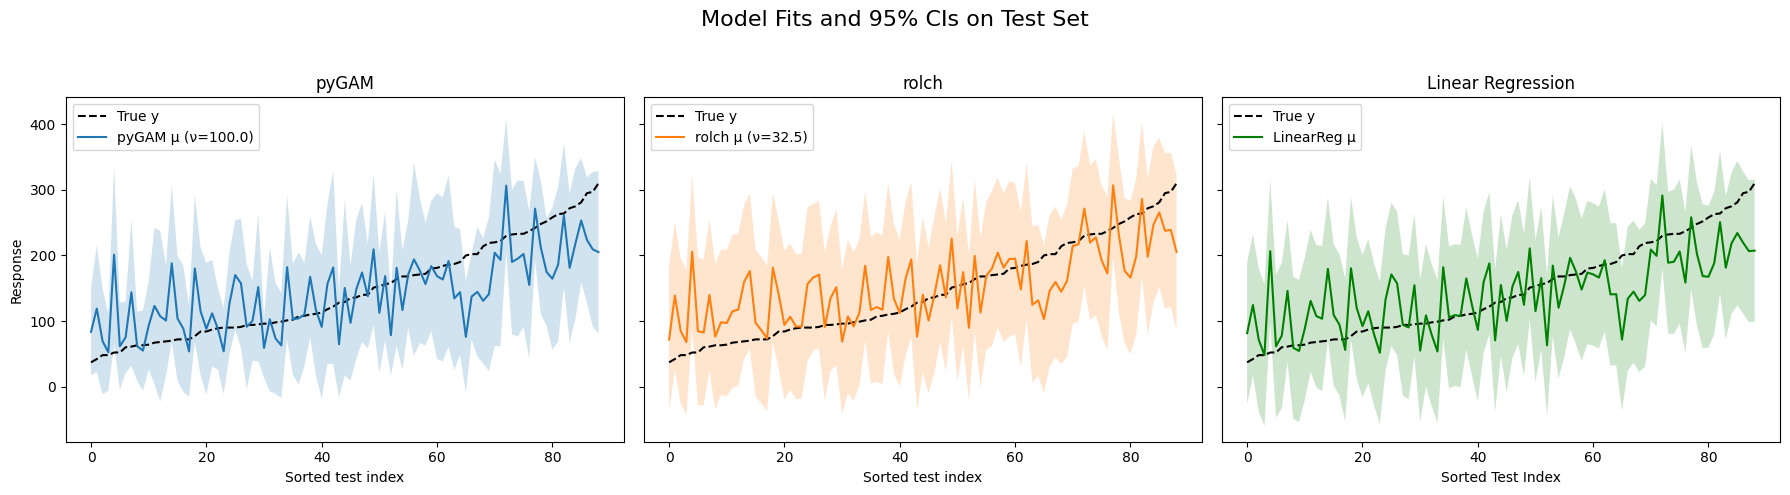

In [18]:
# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. pyGAM
axes[0].plot(y_test_s, 'k--', label="True y")
axes[0].plot(mu_pg, label=f"pyGAM μ (ν={nu_pg:.1f})", color='C0')
axes[0].fill_between(
    np.arange(len(mu_pg)),
    lower_pg,
    upper_pg,
    facecolor='C0',
    edgecolor='none',
    alpha=0.2
)
axes[0].set_title("pyGAM")
axes[0].set_xlabel("Sorted test index")
axes[0].set_ylabel("Response")
axes[0].legend()

# 2. rolch
axes[1].plot(y_test_s, 'k--', label="True y")
axes[1].plot(mu_rl, label=f"rolch μ (ν={nu_rl:.1f})", color='C1')
axes[1].fill_between(
    np.arange(len(mu_rl)),
    lower_rl,
    upper_rl,
    facecolor='C1',
    edgecolor='none',
    alpha=0.2
)
axes[1].set_title("rolch")
axes[1].set_xlabel("Sorted test index")
axes[1].legend()

# 3. Linear Regression
axes[2].plot(y_test_s, 'k--', label="True y")
axes[2].plot(mu_lr, label="LinearReg μ", color='green', linestyle='-')
axes[2].fill_between(
    np.arange(len(mu_lr)),
    lower_obs,
    upper_obs,
    facecolor='green',
    edgecolor='none',
    alpha=0.2
)
axes[2].set_title("Linear Regression")
axes[2].set_xlabel("Sorted Test Index")
axes[2].legend()

plt.suptitle("Model Fits and 95% CIs on Test Set", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()